In [1]:
import sys
sys.path.append("../../src")

import os
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt

from utils.kernel_utils import ColumnwiseRBF, RBF, FourthOrderGaussianKernel, BinaryKernel
from causal_models.proxy_causal_learning import KernelNegativeControlATE
from dsprite_ver2 import *
from utils.ml_utils import data_transform

In [2]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


In [3]:
seed = np.random.randint(1000000)
np.random.seed(seed)
train_dataset = generate_train_dsprite_ver2(n_sample = 2000, rand_seed = seed)
test_dataset = generate_test_dsprite_ver2()
transform_data = True

A = train_dataset.treatment
Y = train_dataset.outcome
Z = train_dataset.treatment_proxy
W = train_dataset.outcome_proxy
do_A = test_dataset.treatment
EY_do_A = test_dataset.structural

In [4]:
if transform_data:
    A_transformed, A_transformer = data_transform(A)
    Z_transformed, Z_transformer = data_transform(Z)
    W_transformed, W_transformer = data_transform(W)
    Y_transformed, Y_transformer = data_transform(Y)
    
    data_size = A_transformed.shape[0]
    A_transformed = jnp.array(A_transformed).reshape(data_size, -1)
    Z_transformed = jnp.array(Z_transformed).reshape(data_size, -1)
    W_transformed = jnp.array(W_transformed).reshape(data_size, -1)
    Y_transformed = jnp.array(Y_transformed).reshape(data_size, -1)

else:
    W_transformed, Z_transformed, A_transformed, Y_transformed, do_A, EY_do_A = jnp.array(W), jnp.array(Z), jnp.array(A), jnp.array(Y), jnp.array(do_A), jnp.array(EY_do_A)

In [5]:
RBF_Kernel_Z = RBF(use_length_scale_heuristic = True, use_jit_call = True,
                   length_scale_heuristic_quantile = 0.5
                  )
RBF_Kernel_W = RBF(use_length_scale_heuristic = True, use_jit_call = True,
                   length_scale_heuristic_quantile = 0.5
                  )
RBF_Kernel_A = RBF(use_length_scale_heuristic = True, use_jit_call = True,
                   length_scale_heuristic_quantile = 0.5
                   )

lambda_ = 0.1
zeta = 5*1e-2
optimize_regularization_parameters = True
lambda_optimization_range = (1e-7, 1.0)
zeta_optimization_range = (1e-7, 1.0)
stage1_perc = 0.5
regularization_grid_points = 150
np.random.seed(seed)
model = KernelNegativeControlATE(
                                 kernel_A = RBF_Kernel_A,
                                 kernel_W = RBF_Kernel_W,
                                 kernel_Z = RBF_Kernel_Z,
                                 lambda_ = lambda_,
                                 zeta = zeta, 
                                 optimize_regularization_parameters = True,
                                 lambda_optimization_range = lambda_optimization_range,
                                 zeta_optimization_range = zeta_optimization_range,
                                 stage1_perc = stage1_perc,
                                 regularization_grid_points = regularization_grid_points,
                                )

In [6]:
model.fit((A_transformed, W_transformed, Z_transformed), Y_transformed)
if transform_data:
    do_A_size = do_A.shape[0]
    do_A_transformed = (A_transformer.transform(do_A)).reshape(do_A_size, -1)
    f_struct_pred_transformed = model.predict(do_A_transformed)
    f_struct_pred = Y_transformer.inverse_transform(f_struct_pred_transformed.reshape(do_A_size, -1)).reshape(do_A_size, -1)
else:
    f_struct_pred = model.predict(do_A)

structured_pred_mse = (np.mean((f_struct_pred.reshape(-1, 1) - EY_do_A.reshape(-1, 1)) ** 2))
structured_pred_mae = (np.mean(np.abs(f_struct_pred.reshape(-1, 1) - EY_do_A.reshape(-1, 1))))
print("Structured function test set MSE: {}".format(structured_pred_mse))
print("Structured function test set MAE: {}".format(structured_pred_mae))

Structured function test set MSE: 33.813761288227525
Structured function test set MAE: 3.7413362632915774


In [7]:
np.min(model.zeta_objective_list)

Array(0.15226153, dtype=float64)

In [8]:
model.lambda_, model.zeta

(Array(0.00151778, dtype=float64), Array(1.e-07, dtype=float64))

In [9]:
from sklearn.metrics import r2_score

r2_score(EY_do_A.reshape(-1, 1), f_struct_pred.reshape(-1, 1))

0.3652026791686359

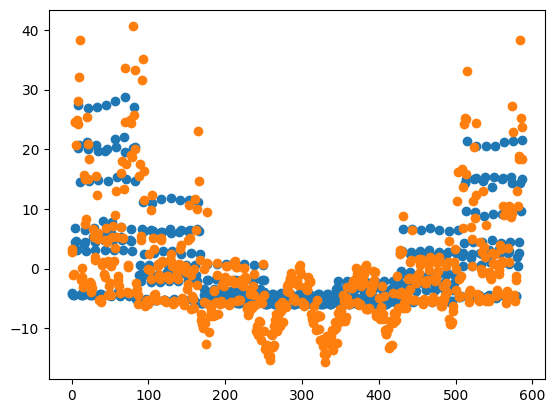

In [10]:
x = np.arange(EY_do_A.shape[0])
plt.scatter(x, EY_do_A)
plt.scatter(x, f_struct_pred)

In [11]:
(model.zeta_objective_list).min().item()

0.1522615259862933